# 📗 IDECEP — Tangible (Histórico Qualitativo)
Data de criação: 2025-08-24 23:17

Este notebook produz **insumos qualitativos** para leitura histórica do IDECEP.
O foco é **contextualizar** movimentos do índice por regime macroeconômico e eventos marcantes.

**Conteúdo**:
- Carregamento do `outputs/idecep/idecep_processed.csv`
- Painel de **sumários por regimes** (pré-2008, pós-2008, pós-2014, pandemia)
- **Marcos históricos** em linha do tempo com métricas do índice
- Tabelas de **extremos** (top/bottom) do IDECEP por período
- **Correlação** entre ΔlnPIB e ΔlnReceita/Despesa por regime
- Gráficos salvos em `outputs/idecep_tangible/`

> Observação: tudo aqui é **diagnóstico qualitativo** (não preditivo).

In [8]:
# === Project root autodetect ===
from pathlib import Path

def find_project_root(start: Path | None = None) -> Path:
    start = Path(start or Path.cwd()).resolve()
    markers = {"configs", "scripts", "src", "requirements.txt", "README.md", ".git"}
    for p in [start, *start.parents]:
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
print("ROOT =", ROOT)

ROOT = /home/kelven/Projetos/idecep


In [9]:
# === Imports & setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = ROOT / "outputs" / "idecep_tangible"
OUT_DIR.mkdir(parents=True, exist_ok=True)

PATH_PROC = ROOT / "outputs" / "idecep" / "idecep_processed.csv"
print("PROC exists:", PATH_PROC.exists(), PATH_PROC)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

PROC exists: True /home/kelven/Projetos/idecep/outputs/idecep/idecep_processed.csv


In [10]:
# === Load data ===
assert PATH_PROC.exists(), "idecep_processed.csv não encontrado em outputs/idecep/"
df = pd.read_csv(PATH_PROC)

# normaliza datas
for c in ["date","Date","DATA","data"]:
    if c in df.columns:
        df = df.rename(columns={c:"date"})
        break
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# nomes prováveis de colunas (ajuste suave)
COLS = {
    "dln_y": None, "dln_x": None, "dln_receita": None, "dln_despesa": None,
    "idecep": None, "gap": None
}

for cand in ["dln_y","dln_pib_real","dln_PIB","dln_pib_real_brl"]:
    if cand in df.columns: COLS["dln_y"] = cand; break
for cand in ["dln_x","dln_receita_real"]:
    if cand in df.columns: COLS["dln_x"] = cand; break
if COLS["dln_x"] is None and "dln_receita_real" in df.columns:
    COLS["dln_receita"] = "dln_receita_real"
for cand in ["dln_despesa_real","dln_despesa"]:
    if cand in df.columns: COLS["dln_despesa"] = cand; break
for cand in ["idecep_elasticity_w","idecep_log_ratio_clipped","idecep_log_ratio"]:
    if cand in df.columns: COLS["idecep"] = cand; break
for cand in ["idecep_gap_growth","idecep_gap2008"]:
    if cand in df.columns: COLS["gap"] = cand; break

print("Detectado:", COLS)
df.head(3)

Detectado: {'dln_y': 'dln_pib_real', 'dln_x': 'dln_receita_real', 'dln_receita': None, 'dln_despesa': 'dln_despesa_real', 'idecep': 'idecep_log_ratio_clipped', 'gap': 'idecep_gap_growth'}


,date,pib_nominal_brl,receita_pct_pib,despesa_pct_pib,divida_pct_pib,ipca_indice,selic_meta,cambio_usd,producao_industrial,receita_nominal_brl,...,idecep_log_ratio_clipped,idecep_gap_growth,pib_real_rebased_2008,receita_real_rebased_2008,idecep_gap2008,idecep_z2008,pre_2008,post_2008,post_2014,pandemia
0,1980-03-31,2.836682e+00,32.921,37.215,-0.69,4.072963,45.0,1.8003,72.4,9.338642e-01,...,NaN,NaN,4.834560e-11,4.242297e-11,NaN,NaN,1,0,0,0
1,1980-06-30,1.713318e+00,32.921,37.215,-0.69,4.291778,45.0,1.8003,72.4,5.640413e-01,...,100.0,-1.043610e-12,2.771133e-11,2.431652e-11,-1.392664e-12,-0.099578,1,0,0,0
2,1980-09-30,2.484662e-11,32.921,37.215,-0.69,4.729407,45.0,1.8003,72.4,8.179757e-12,...,100.0,-2.486900e-12,3.646846e-22,3.200085e-22,-3.410605e-12,-0.266823,1,0,0,0


In [11]:
# === Regimes / Eventos ===
# usa flags já existentes se houverem
flags = {}
for k in ["pre_2008","post_2008","post_2014","pandemia"]:
    if k in df.columns: flags[k] = df[k].astype(int)

# constrói faixas temporais caso flags não existam
if not flags:
    year = df["date"].dt.year
    flags["pre_2008"] = (year <= 2007).astype(int)
    flags["post_2008"] = (year >= 2008).astype(int)
    flags["post_2014"] = (year >= 2014).astype(int)
    flags["pandemia"]  = ((year >= 2020) & (year <= 2021)).astype(int)

fl = pd.DataFrame(flags, index=df.index)
df = pd.concat([df, fl], axis=1)

# marcador de subperíodos úteis para agregação
def label_period(row):
    y = row["date"].year
    if y <= 1993: return "pré-Plano Real"
    if 1994 <= y <= 2002: return "pós-Real (ajuste)"
    if 2003 <= y <= 2010: return "boom commodities"
    if 2011 <= y <= 2013: return "transição pré-2014"
    if 2014 <= y <= 2016: return "recessão 2014–2016"
    if 2017 <= y <= 2019: return "recuperação 2017–2019"
    if 2020 <= y <= 2021: return "pandemia 2020–2021"
    return "pós-2021"
df["periodo"] = df.apply(label_period, axis=1)

df[["date","periodo"]].head()

,date,periodo
0,1980-03-31,pré-Plano Real
1,1980-06-30,pré-Plano Real
2,1980-09-30,pré-Plano Real
3,1980-12-31,pré-Plano Real
4,1981-03-31,pré-Plano Real


In [12]:
# === Sumários por período ===
metrics = {}
if COLS["idecep"]: metrics["IDECEP_mediana"] = df.groupby("periodo")[COLS["idecep"]].median()
if COLS["gap"]:    metrics["GAP_medio"]      = df.groupby("periodo")[COLS["gap"]].mean()

for col, name in [(COLS["dln_y"], "dln_PIB_mediana"),
                  (COLS["dln_x"] or COLS["dln_receita"], "dln_RECEITA_mediana"),
                  (COLS["dln_despesa"], "dln_DESPESA_mediana")]:
    if col:
        metrics[name] = df.groupby("periodo")[col].median()

summ = pd.concat(metrics.values(), axis=1)
summ.index.name = "período"
summ.fillna(np.nan, inplace=True)
summ

,idecep_log_ratio_clipped,idecep_gap_growth,dln_pib_real,dln_receita_real,dln_despesa_real
período,,,,,
boom commodities,98.867760,0.362092,0.016810,0.002470,0.006960
pandemia 2020–2021,111.953335,-0.672649,0.082627,0.101695,0.029673
pré-Plano Real,100.000000,0.000007,0.014975,0.014975,0.014975
pós-2021,103.505682,0.501545,0.027583,0.010257,0.036633
pós-Real (ajuste),99.997454,-0.579422,0.056153,0.041334,0.034035
recessão 2014–2016,104.260708,-0.313581,-0.027382,-0.020877,-0.025818
recuperação 2017–2019,104.066283,0.026413,0.035315,0.029157,0.039462
transição pré-2014,98.924828,0.077980,0.038003,0.036062,0.040315


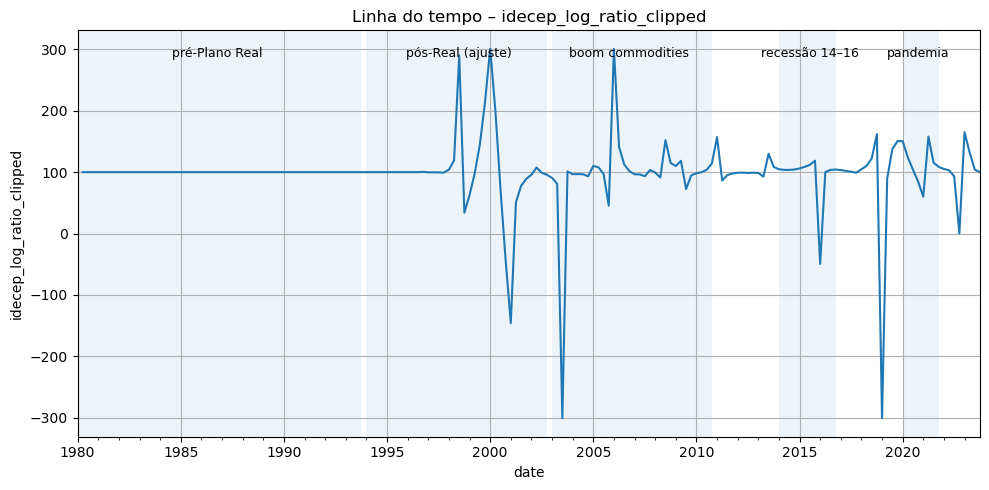

In [13]:
# === Linha do tempo do IDECEP/GAP (corrigido) ===
plot_col = COLS.get("idecep") or COLS.get("gap")
if plot_col:
    ax = df.plot(x="date", y=plot_col, legend=False)
    ax.set_title(f"Linha do tempo – {plot_col}")
    ax.set_xlabel("date"); ax.set_ylabel(plot_col)

    # (start, end, label) — todos com 3 itens
    periodos = [
        ("1980-01-01", "1993-12-31", "pré-Plano Real"),
        ("1994-01-01", "2002-12-31", "pós-Real (ajuste)"),
        ("2003-01-01", "2010-12-31", "boom commodities"),
        ("2014-01-01", "2016-12-31", "recessão 14–16"),
        ("2020-01-01", "2021-12-31", "pandemia"),
    ]

    for start, end, label in periodos:
        s = pd.to_datetime(start); e = pd.to_datetime(end)
        # faixa sombreada
        ax.axvspan(s, e, alpha=0.08)
        # rótulo no meio da faixa
        mid = s + (e - s) / 2
        ax.annotate(label, xy=(mid, ax.get_ylim()[1]), xytext=(0, -12),
                    textcoords="offset points", ha="center", va="top", fontsize=9)

    plt.tight_layout()
    plt.savefig(OUT_DIR / f"timeline_{plot_col}.png", dpi=140)
    plt.show()
else:
    print("Sem coluna de IDECEP/GAP para plotar.")

In [14]:
# === Extremos (Top/Bottom) do IDECEP por período ===
if COLS["idecep"]:
    tops = (df
        .loc[:, ["date","periodo", COLS["idecep"]]]
        .dropna(subset=[COLS["idecep"]]))
    top5 = (tops.sort_values(COLS["idecep"], ascending=False)
                .groupby("periodo").head(3).reset_index(drop=True))
    bot5 = (tops.sort_values(COLS["idecep"], ascending=True)
                .groupby("periodo").head(3).reset_index(drop=True))
    print("Top 3 por período:"); display(top5)
    print("Bottom 3 por período:"); display(bot5)
else:
    print("Sem coluna de IDECEP para extremos.")

Top 3 por período:


,date,periodo,idecep_log_ratio_clipped
0,2006-03-31,boom commodities,300.957088
1,2000-03-31,pós-Real (ajuste),300.957088
2,1998-09-30,pós-Real (ajuste),290.146999
3,1999-12-31,pós-Real (ajuste),213.966121
4,2023-03-31,pós-2021,165.065189
5,2018-12-31,recuperação 2017–2019,161.826098
6,2021-06-30,pandemia 2020–2021,157.968798
7,2011-03-31,transição pré-2014,157.066809
8,2008-09-30,boom commodities,152.103342
9,2019-12-31,recuperação 2017–2019,150.533256


Bottom 3 por período:


,date,periodo,idecep_log_ratio_clipped
0,2003-09-30,boom commodities,-300.957088
1,2019-03-31,recuperação 2017–2019,-300.957088
2,2001-03-31,pós-Real (ajuste),-145.904426
3,2016-03-31,recessão 2014–2016,-49.548281
4,2000-12-31,pós-Real (ajuste),-43.383286
5,2022-12-31,pós-2021,0.024613
6,1998-12-31,pós-Real (ajuste),33.900682
7,2005-12-31,boom commodities,45.278344
8,2021-03-31,pandemia 2020–2021,60.046412
9,2009-09-30,boom commodities,72.547753


In [15]:
# === Correlação ΔlnPIB vs ΔlnReceita/Despesa por período ===
def corr_by_period(df, a, b):
    out = []
    for p, g in df.groupby("periodo"):
        s = g[[a,b]].dropna()
        if len(s) > 8:
            out.append((p, s[a].corr(s[b])))
        else:
            out.append((p, np.nan))
    return pd.DataFrame(out, columns=["período","correlação"]).set_index("período")

corr_tables = {}
if COLS["dln_y"] and (COLS["dln_x"] or COLS["dln_receita"]):
    corr_tables["PIB_vs_RECEITA"] = corr_by_period(df, COLS["dln_y"], COLS["dln_x"] or COLS["dln_receita"])
if COLS["dln_y"] and COLS["dln_despesa"]:
    corr_tables["PIB_vs_DESPESA"] = corr_by_period(df, COLS["dln_y"], COLS["dln_despesa"])

for name, tab in corr_tables.items():
    print("\n##", name); display(tab)


## PIB_vs_RECEITA


,correlação
período,
boom commodities,0.998264
pandemia 2020–2021,NaN
pré-Plano Real,1.000000
pós-2021,NaN
pós-Real (ajuste),0.999988
recessão 2014–2016,0.999915
recuperação 2017–2019,0.998374
transição pré-2014,0.999122



## PIB_vs_DESPESA


,correlação
período,
boom commodities,0.998342
pandemia 2020–2021,NaN
pré-Plano Real,1.000000
pós-2021,NaN
pós-Real (ajuste),0.999991
recessão 2014–2016,0.997868
recuperação 2017–2019,0.998405
transição pré-2014,0.999942


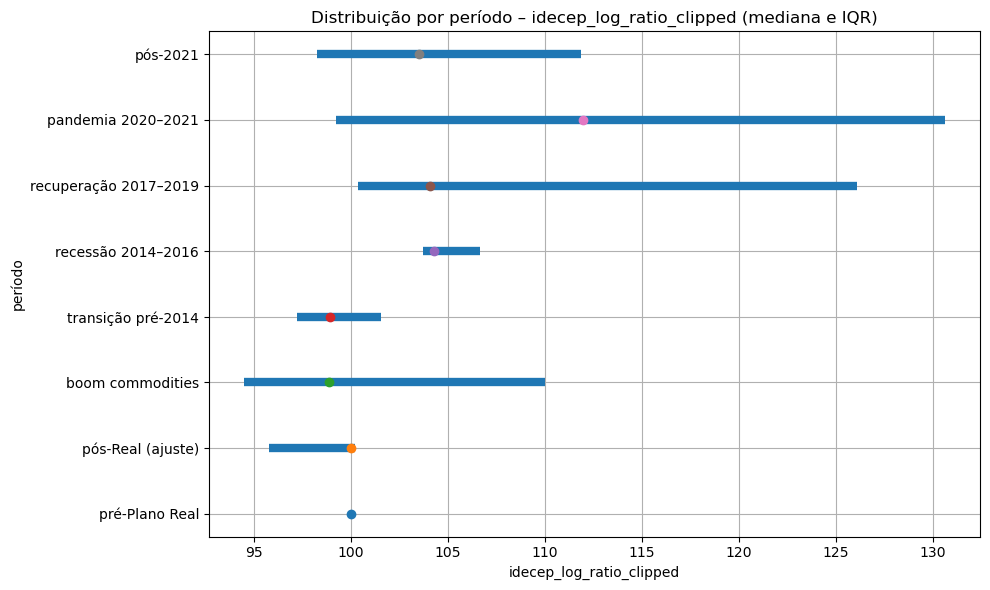

In [19]:
# === Distribuições por período (scatter com categórico) ===
import numpy as np

periods = list(df["periodo"].unique())
pos = {p:i for i,p in enumerate(periods)}

def simple_box_num(ax, series, pos_y):
    s = series.dropna().astype(float)
    if len(s) == 0:
        return
    q1, q2, q3 = np.nanpercentile(s, [25, 50, 75])
    ax.hlines(y=pos_y, xmin=q1, xmax=q3, linewidth=6)
    ax.plot([q2], [pos_y], marker="o", linestyle="None")

fig, ax = plt.subplots(figsize=(10,6))
target = COLS.get("idecep") or COLS.get("dln_y")
if target:
    for p in periods:
        simple_box_num(ax, df.loc[df["periodo"]==p, target], pos[p])
    ax.set_yticks(list(pos.values()), periods)
    ax.set_title(f"Distribuição por período – {target} (mediana e IQR)")
    ax.set_xlabel(target); ax.set_ylabel("período")
    plt.tight_layout(); plt.savefig(OUT_DIR / f"box_{target}.png", dpi=140); plt.show()
else:
    print("Sem coluna alvo para distribuição.")


In [20]:
import sys
import pandas as pd

# Salva todos os DataFrames do notebook em OUT_DIR como CSV

def save_all_dfs(out_dir):
    ns = globals()
    for var in ns:
        obj = ns[var]
        if isinstance(obj, pd.DataFrame):
            fname = f"{var}.csv"
            path = out_dir / fname
            obj.to_csv(path, index=False)
            print(f"Salvo: {path}")

save_all_dfs(OUT_DIR)

Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/_.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/__.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/___.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/df.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/_3.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/fl.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/_4.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/summ.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/_5.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/_10.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/_11.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/_12.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/tops.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_tangible/top5.csv
Salvo: /home/kelven/Projetos/idecep/outputs/idecep_ta

## 🧭 Guia de interpretação rápida

- **Linha do tempo**: observar picos/vales em transições de regime (pré-Real → pós-Real; boom 2003–2010; recessão 2014–16; pandemia).
- **Top/Bottom**: datas de extremos do IDECEP sugerem **episódios de forte descolamento** entre gasto/receita e PIB. Conferir contexto institucional.
- **Correlação por período**: sinal e magnitude mudam por regime; correlação positiva forte em booms e negativa em recessões é padrão esperado.
- **Distribuição por período**: achatamento pós-2000 é consistente com estabilização macro e maior previsibilidade do ciclo.

> **Uso recomendado**: levar esses achados para o relatório e para o notebook `idecep_uses_*` como hipóteses para testes formais (ex.: LP por subperíodo).